# Assignment1 Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
!pip install wordcloud
from wordcloud import WordCloud

import html
import re
import nltk
from nltk.tokenize import RegexpTokenizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from scipy import stats
import random
random.seed()

###  Import original data and stop words

In [2]:
generic_tweets = pd.read_csv('generic_tweets.txt')
airline_tweets = pd.read_csv('US_airline_tweets.csv')

with open('stop_words.txt','r') as f:
    stop_words = f.read().split('\n')

In [3]:
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
airline_tweets.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


### Q1 Data Cleaning
Create a data cleaner to perform the data cleaning procedure in sequence:

- Encode according to ASCII
- Remove html tags and attributes
- Remove URLs
- Change to lower cases
- Collect @tag message to determine airline
- Tokenize word stream
- Remove stop words
- Remove all non-alphanumerical charactors

In [5]:
class DataCleaner(object):
    def __init__(self,stop_words=[""], remove_steps = []):
        super().__init__()
        self.hashtags = str()
        self.remove_steps = remove_steps
        self.stop_words = stop_words
        self.procedures = [getattr(self,procedure) for procedure in \
                        [step for step in sorted(dir(self)) if step.startswith("step_")]]
        # remove some procedures according to users' needs
        for i in sorted(self.remove_steps,reverse=True):
                self.procedures.pop(i-1)

    #use reduce to sequentially clean the raw data, equivelent to funcN(...func2(func1(data)))
    def clean(self, data):
            return reduce(lambda data,func:func(data),[data]+self.procedures),self.hashtags

    # Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    def step_01_to_ascii(self,data):
        return html.unescape(data)

    # Remove html tags and attributes in form of <...>
    def step_02_remove_html_tag(self,data):
        return re.sub(r"\s*<.*?>",'', data)

    # Remove url in form of (http or https://)address.domain(/file)
    def step_03_remove_url(self,data):
        return re.sub(r'\s*(?:https?:\/\/)?[\w.-]+(?:\.[\w.-]+)+[\w\-._~:/?#[\]@!\$&\'\(\)\*\+,;=.]+','',data)

    # Change all characters in the text to lowercase.
    def step_04_to_lower(self,data):
        return data.lower()

    # Collect @ tag message
    def step_05_hashtag_collection(self,data):
        self.hashtags = ' '.join(re.findall(r'(?<=@)[^\s]+\s?',data))
        return re.sub(r'@.*?\s','',data)

    # Tokenize the word stream
    def step_06_tokenization(self,data):
        tokenizer = RegexpTokenizer(r'\w+')
        words_list = tokenizer.tokenize(data)
        return ' '.join(words_list)

    # Remove stop words
    def step_07_remove_stop_words(self,data):
        words = data.split()
        new_data = [word for word in words if word not in self.stop_words]
        return ' '.join(new_data) #clean up empty charactor

    # Remove non alphanumeric characters except space
    def step_08_remove_nonAlphaNumerical(self,data):
        return re.sub(r'[^\s\w]+','',data)

#### Clean generic_tweets

In [10]:
geneCleaner = DataCleaner(stop_words,[5])
generic_tweets['clean_text'],_ = np.vectorize(geneCleaner.clean)(generic_tweets['text'])
generic_tweets.head(3)

,class,id,date,query,user,text,clean_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww bummer shoulda david carr thir...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset t update facebook texting cry result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dived times ball managed save 50 rest...


#### Clean airline_tweets

In [8]:
airCleaner = DataCleaner(stop_words)
airline_tweets['clean_text'],airline_tweets['@_tags'] = np.vectorize(airCleaner.clean)(airline_tweets['text'])
airline_tweets.head(3)

### Q2 Exploratory analysis

When cleaning data Q1, we created "@_tag" column which contains word in tweetertext that starts with '@'. This piece of information contains most of the airline information. 

We check @_tags and find that there are a total of 8 airlines in our dataset. Also there is one tweeter that doesn't indicate airline.

We use the function "LabelAir" to get the airline and do exploratory analysis.

In [11]:
def LabelAir(data,text):
    airlines = ['americanair','usairways','bostonlogan','united',\
               'deltaassist','jetblue','southwestair','virginamerica']
    for airline in airlines:
        if data.find(airline)>=0:
            return airline
    for airline in airlines:
        if text.lower().find(airline)>=0:
            return airline
    return "Unknown"

airline_tweets['airline'] = [LabelAir(a,b) for a, b in zip(airline_tweets['@_tags'],airline_tweets['text'])]
# LabelAir(airline_tweets.iloc[6184]['@_tags'],airline_tweets.iloc[6184]['text'])
airline_tweets.head(3)

,id,sentiment,negative_reason,user,retweet_count,text,clean_text,@_tags,airline
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...,ve commercials tacky,virginamerica,virginamerica
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...,aggressive blast obnoxious entertainment guest...,virginamerica,virginamerica
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...,big bad thing,virginamerica,virginamerica


#### Draw a bar to show the distribution of the US airlines of the tweets

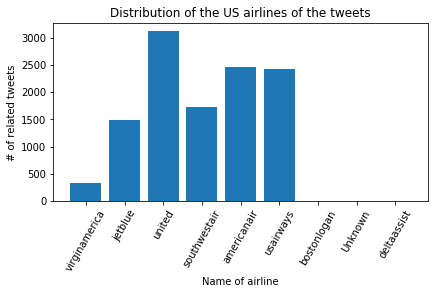

In [12]:
# plot a histogram
x = Counter(airline_tweets['airline'])
l = range(len(x.keys()))
plt.bar(l, x.values())
plt.xticks(l, x.keys(),rotation=60)
plt.xlabel('Name of airline')
plt.ylabel('# of related tweets')
plt.title('Distribution of the US airlines of the tweets')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

The distribution results above show the class imbalance of Airline usage in different America Airlines. The most tweeters are from United Airline while very little from BostonLogan and DeltaAssist. 

#### We draw the WordCloud to show the public's positive voice in generic_tweeting. To make the words more readable, we eliminate some of the steps when cleaning data.

In [13]:
readerCleaner = DataCleaner(stop_words,[5,6])
generic_positive_voice,_ = np.vectorize(readerCleaner.clean)(generic_tweets[generic_tweets['class']==4]['text'])

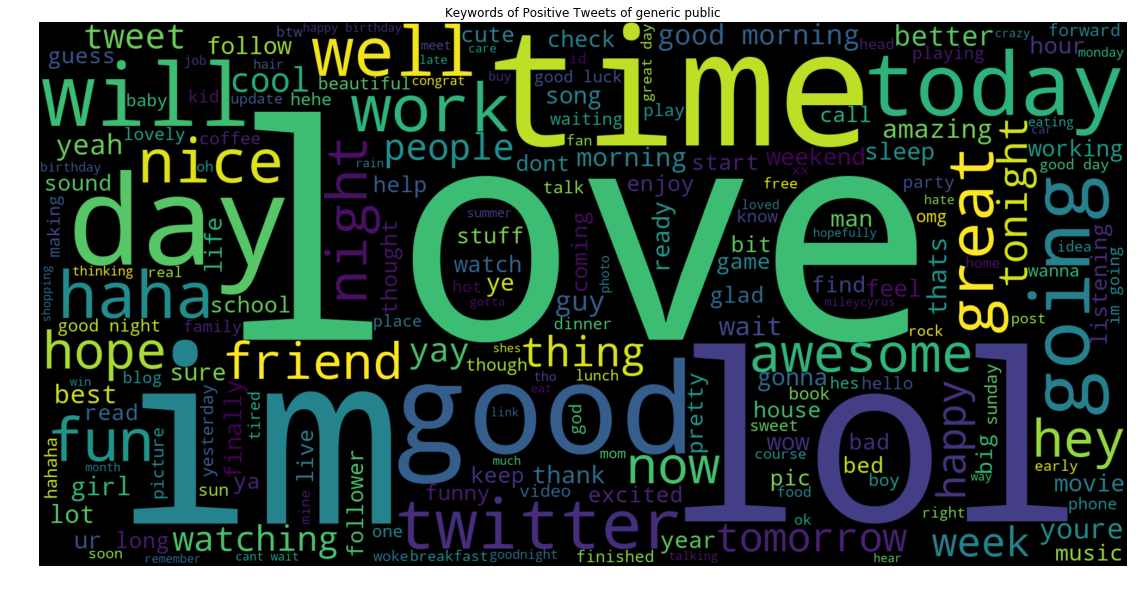

In [14]:
generic_positive = " ".join([j for i in generic_positive_voice for j in i.split()])
generic_positive_wordcloud = WordCloud(width = 2000, height = 1000).generate(generic_positive)

plt.figure(figsize=(20,10))
plt.imshow(generic_positive_wordcloud, interpolation='bilinear')
plt.title('Keywords of Positive Tweets of generic public')
plt.axis("off")
plt.show()

#### We draw the WordCloud to show the public's keywords of negative voice in airline_tweets. To make the words more readable, we eliminate some of the steps when cleaning data.

In [15]:
airline_negative_voice,_ = np.vectorize(readerCleaner.clean)(airline_tweets[airline_tweets['sentiment']=='negative']['text'])

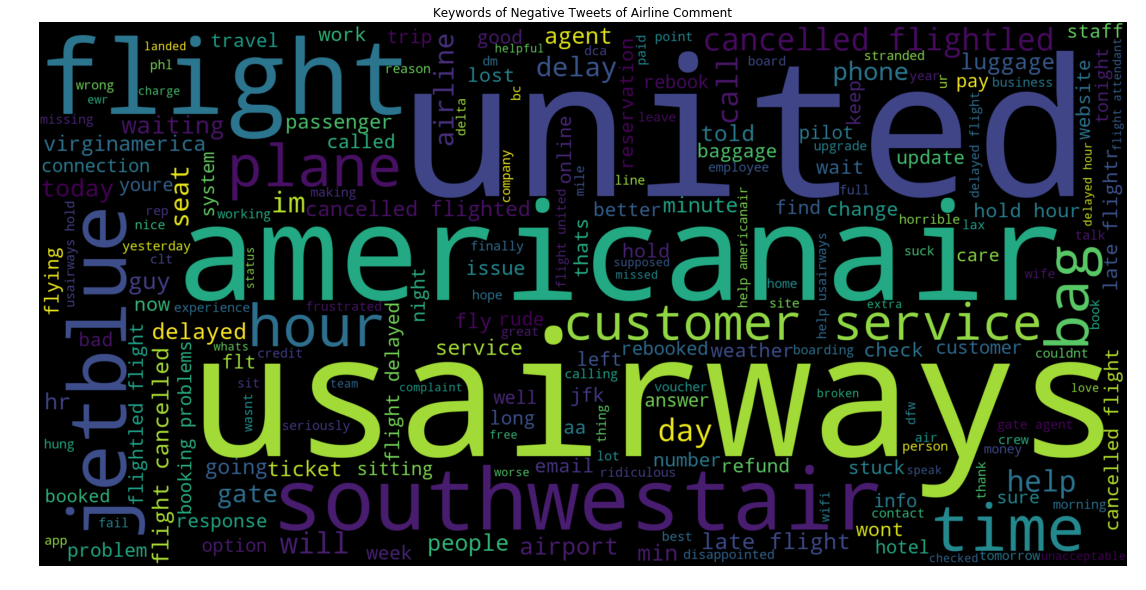

In [16]:
airline_negative = " ".join([j for i in airline_negative_voice for j in i.split()])
airline_negative_wordcloud = WordCloud(width = 2000, height = 1000).generate(airline_negative)

plt.figure(figsize=(20,10))
plt.imshow(airline_negative_wordcloud, interpolation='bilinear')
plt.title('Keywords of Negative Tweets of Airline Comment')
plt.axis("off")
plt.show()

### Q3 Model Preparation
Prepare the data for model training and testing in sequense:

- Create whole dataset with "tf-idf" method
- Split data for 70% training use and 30% test use

In [18]:
'''
Create a class "DataGenerator" that can be used to generate training and testing data from original DataFrame.
    For choosing features, I provide three methods:"tf-idf"/"most_common_bi"/"most_common_freq", 
        where "tf-idf"takes all the terms that appear in data into account,
        and  "most_common_bi" only takes the most common "top" terms into account and does binary encoding,
        and  "most_common_freq" only takes the most common "top" terms into account and does frequency encoding.
    For spliting dataset, I provide one method which enables you to determine if you want validation set.
'''

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

class DataGenerator(object):
    def __init__(self,dataFrame):
        super().__init__()
        self.dataFrame = dataFrame

    def dataGenerate(self,feature_column,label_column,method="tf-idf",top=1000):
        if method=="tf-idf":
            return self._dataGene_tf_idf(feature_column,label_column)
        elif method=="most_common_bi":
            return self._dataGene_most_bi(feature_column,label_column,top)
        elif method=="most_common_freq":
            return self._dataGene_most_freq(feature_column,label_column,top)
        else:
            print("Please check your data generation method.")
            return None

    def _dataGene_tf_idf(self,feature_column,label_column):
        # transform all text data into TF-IDF features
        tfidf_vector = TfidfVectorizer(stop_words='english')
        X = tfidf_vector.fit_transform(self.dataFrame[feature_column])
        Y = self.dataFrame[label_column]
        return X,Y,tfidf_vector

    def _dataGene_most_bi(self,feature_column,label_column,top=1000):
        news_cnt = self.corpus_count_words(self.dataFrame[feature_column])
        # Feature selection: we choose the word with high term frequency in whole text collections
        word_list = [word for (word, freq) in news_cnt.most_common(top)]
        df_rows = []
        for text in self.dataFrame[feature_column]:
            text_words_counter = self.corpus_count_words([text])
            df_rows.append([1 if text_words_counter[word]>0 else 0 for word in word_list])
        X = pd.DataFrame(df_rows, columns = word_list)
        Y = self.dataFrame[label_column]
        return X, Y, word_list

    def _dataGene_most_freq(self,feature_column,label_column,top=1000):
        news_cnt = self.corpus_count_words(self.dataFrame[feature_column])
        # Feature selection: we choose the word with high term frequency in whole text collections
        word_list = [word for (word, freq) in news_cnt.most_common(top)]
        df_rows = []
        for text in self.dataFrame[feature_column]:
            text_words_counter = self.corpus_count_words([text])
            df_rows.append([text_words_counter[word] if text_words_counter[word]>0 else 0 for word in word_list])

        X = pd.DataFrame(df_rows, columns = word_list)
        Y = self.dataFrame[label_column]
        return X, Y, word_list

    def corpus_count_words(self,dataSeries):
        stop = stopwords.words('english')
        wordnet_lemmatizer = WordNetLemmatizer()
        word_counter = Counter()
        for text in dataSeries:
            words = [wordnet_lemmatizer.lemmatize(i) for i in text.split() if i not in stop]
            word_counter.update(words)
        return word_counter

    def split_data(self,X,Y,percent=[0.7,0.3],random_state=42):
        if len(percent) == 2:
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=percent[1], random_state=random_state)
            return X_train,X_test,y_train,y_test
        elif len(percent) == 3:
            print("You also create validation set...")
            X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=percent[1], random_state=random_state)
            X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=percent[2]/(1-percent[1]), random_state=random_state)
            return X_train,X_valid,X_test,y_train,y_valid,y_test
        else:
            print("Please check you percent.\n")
            return None

[nltk_data] Downloading package stopwords to /home/hanwen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
generic_tweets['class'] = [1 if row['class']==4 else 0 for index,row in generic_tweets.iterrows()]

In [20]:
generic_gene = DataGenerator(generic_tweets)
generic_X, generic_Y, feature_list = generic_gene.dataGenerate("clean_text","class")
generic_X_train,generic_X_test,generic_y_train,generic_y_test = generic_gene.split_data(generic_X,generic_Y)

### Q4 Model implementation

Create a classifiers class to develop a set of classifiers (currently SVM, Logistic Regression, Multinomial Naive Bayes and Bernoulli Naive Bayes). We could constructe those classifiers by training with default hyper-parameters only or train with hyper-parameters tuning. 

In [28]:
from collections import OrderedDict
from sklearn.naive_bayes import BernoulliNB as bnb
from sklearn.svm import SVC as svc
from sklearn.linear_model import LogisticRegression as lr
from sklearn.naive_bayes import MultinomialNB as mnb
from sklearn.naive_bayes import BernoulliNB as bnb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc

class Classifier(object):
    def __init__(self,train_data,train_labels):
        super().__init__()
        self.train_data = train_data
        self.train_labels = train_labels
        self.models=OrderedDict([('SVM',[svc(kernel='linear',C=1.0),dict(C=np.arange(1,10))]),\
                            ('LogisticRegression',[lr(C=1.1),dict(C=np.arange(0.1,3,0.2))]),\
                            ('MultinomialNB',[mnb(alpha=7.1),dict(alpha=np.arange(0.1,10,1))]),\
                            ('BernoulliNB',[bnb(alpha=3.1),dict(alpha=np.arange(0.1,10,1))])])

    def train_model(self,model_name,ifhyper_tune=False,hyper_paras=""):
        model = self.models[model_name][0]
        if ifhyper_tune:
            if not hyper_paras:
                hyper_paras = self.models[model_name][1]
            # Grid search method for hyper-parameter tuning in which we use 10-fold cross validation
            grid = GridSearchCV(model, hyper_paras, cv=10, scoring='accuracy', n_jobs=-1) 

            grid.fit(self.train_data, self.train_labels)
            print('\n The best score of model {} through 10-cross validation is {}, with the best hyper-parameter {}\n'\
                .format(model_name, grid.best_score_, grid.best_params_))

            # Best model
            best_model = grid.best_estimator_
        else:
            best_model = model.fit(self.train_data,self.train_labels)
        train_pred = best_model.predict(self.train_data)
        print('Train accuracy of {} model is {}\n'.format(model_name,accuracy_score(self.train_labels,train_pred)))
        return best_model, accuracy_score(self.train_labels,train_pred)

    def test_model(self,best_model,test_data,test_labels,if_report=False,model_name=""):
        test_pred = best_model.predict(test_data)
        
        cm = confusion_matrix(test_labels, test_pred)
        #test accuracy
        print('Model {} has test accuracy {}\n'.format(model_name, accuracy_score(test_labels,test_pred)))
        #test result report
        if if_report:
            print('Test result report:\n\n', classification_report(test_labels, test_pred),'\n')
            if len(set(test_labels))==2:
                test_score = best_model.predict_proba(test_data)
                print('ROC plot and corresponding AUC:\n')
                self.plot_roc(test_labels,test_score)
            else:
                self.plot_confusion_matrix(cm)

    def plot_roc(self,true, score):
        preds = score[:,1]
        fpr, tpr, threshold = roc_curve(true, preds)
        roc_auc = auc(fpr, tpr)
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')

    def plot_confusion_matrix(self,cm):
        # plot the confusion matrix
        plt.figure(figsize=(10,10))
        plt.matshow(cm, fignum=1)

        # add labels for all targets
        num_targets = cm.shape[0]
        plt.xticks(list(range(num_targets+1)))
        plt.yticks(list(range(num_targets+1)))

#### Train a logistic regression model on the training data and obtain the result below:

In [29]:
generic_cli = Classifier(generic_X_train,generic_y_train)
best_gene, _ = generic_cli.train_model('LogisticRegression')

Train accuracy of LogisticRegression model is 0.8266642857142857



#### Test the obtained model using test data and obtain the result below:

Model  has test accuracy 0.7404833333333334

Test result report:

              precision    recall  f1-score   support

          0       0.76      0.70      0.73     29851
          1       0.72      0.78      0.75     30149

avg / total       0.74      0.74      0.74     60000
 

ROC plot and corresponding AUC:



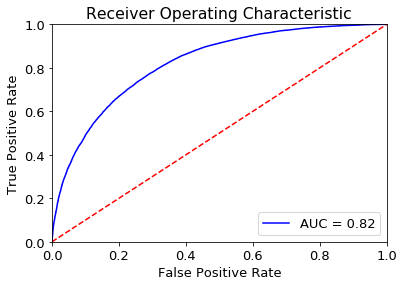

In [30]:
generic_cli.test_model(best_gene,generic_X_test,generic_y_test,True)

#### Evaluate the same model on the US airline data and get the result below:

In [31]:
airline_tweets['class'] = [1 if row['sentiment']=='positive' else 0 for index,row in airline_tweets.iterrows()]
airline_X = feature_list.transform(airline_tweets['clean_text'])

Model  has test accuracy 0.7536608612771857

Test result report:

              precision    recall  f1-score   support

          0       0.93      0.74      0.83      9178
          1       0.44      0.79      0.57      2363

avg / total       0.83      0.75      0.77     11541
 

ROC plot and corresponding AUC:



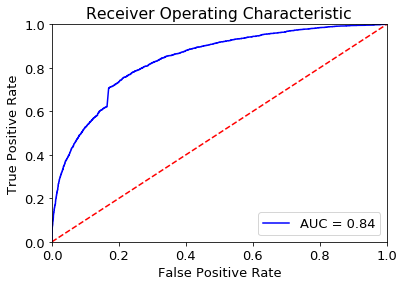

In [32]:
generic_cli.test_model(best_gene,airline_X,airline_tweets['class'],True)

#### Split the negative US airline tweets into training data (70%) and test data (30%). Train a multi-class logistic regression model to predict the reason for the negative tweets. 

In [36]:
neg_airline_tweets = airline_tweets[airline_tweets['sentiment']=='negative']
all_reason = set(neg_airline_tweets['negative_reason'])
print(all_reason)

{'Flight Booking Problems', 'Late Flight', 'Flight Attendant Complaints', 'Bad Flight', "Can't Tell", 'Customer Service Issue', 'Damaged Luggage', 'Lost Luggage', 'longlines', 'Cancelled Flight'}


In [40]:
# From the result above, we can learn that there are a total of 10 reasons for negative sentiment. 
# We map different reasons to different labe.

def LabelReason(data):
    all_reason = {'Bad Flight':0,"Can't Tell":1,'Cancelled Flight':2,'Customer Service Issue':3,'Damaged Luggage':4,\
                  'Flight Attendant Complaints':5,'Flight Booking Problems':6,'Late Flight':7,'Lost Luggage':8,'longlines':9}
    return all_reason[data]
neg_airline_tweets2 = neg_airline_tweets.copy()
neg_airline_tweets2.loc[:,'class'] = np.vectorize(LabelReason)(neg_airline_tweets['negative_reason'])
neg_airline_tweets2.head()

,id,sentiment,negative_reason,user,retweet_count,text,clean_text,@_tags,airline,class
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...,aggressive blast obnoxious entertainment guest...,virginamerica,virginamerica,0
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...,big bad thing,virginamerica,virginamerica,1
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,seriously pay 30 flight seats didn t playing b...,virginamerica,virginamerica,1
11,5.702820e+17,negative,Late Flight,smartwatermelon,0,@VirginAmerica SFO-PDX schedule is still MIA.,sfo pdx schedule mia,virginamerica,virginamerica,7
13,5.702770e+17,negative,Bad Flight,heatherovieda,0,@VirginAmerica I flew from NYC to SFO last we...,flew nyc sfo week couldn t fully sit seat larg...,virginamerica,virginamerica,0


In [41]:
neg_gene = DataGenerator(neg_airline_tweets2)
neg_X, neg_Y,neg_feature = neg_gene.dataGenerate("clean_text","class")
neg_X_train,neg_X_test,neg_y_train,neg_y_test = neg_gene.split_data(neg_X,neg_Y)

In [42]:
neg_cli = Classifier(neg_X_train,neg_y_train)
best_neg,_ = neg_cli.train_model('LogisticRegression')

Train accuracy of LogisticRegression model is 0.7467310087173101



Model  has test accuracy 0.5962236746550472

Test result report:

              precision    recall  f1-score   support

          0       0.60      0.21      0.31       159
          1       0.48      0.37      0.42       359
          2       0.80      0.69      0.74       261
          3       0.54      0.84      0.66       875
          4       0.00      0.00      0.00        20
          5       0.61      0.14      0.23       137
          6       0.61      0.17      0.27       145
          7       0.65      0.71      0.68       517
          8       0.73      0.65      0.69       226
          9       1.00      0.02      0.04        55

avg / total       0.61      0.60      0.56      2754
 



/home/hanwen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


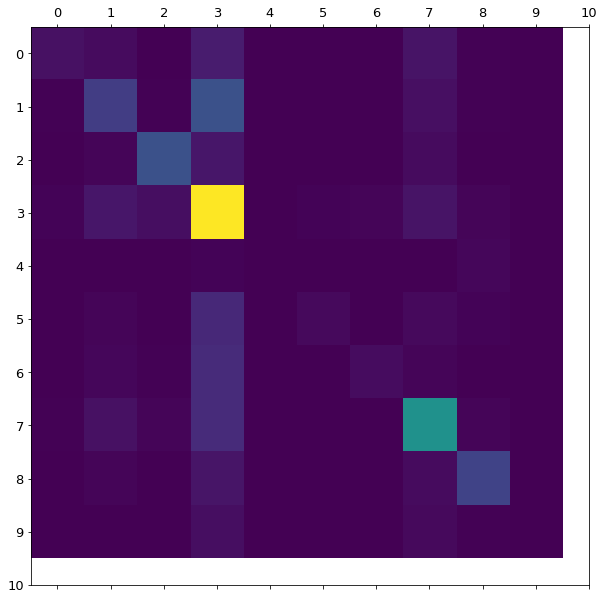

In [43]:
neg_cli.test_model(best_neg,neg_X_test,neg_y_test,True)

### Q5 Answer the research questions

Based on the outputs of your first model, describe the results of the analysis and discuss your interpretation of the results. Explain how each airline is viewed in the public eye based on the sentiment value. 

Based on the second model, provide a few reasons why your model failed to predict the correct negative reasons. Back up your reasoning with examples from the test sets. 

For both models, suggest one way you can improve the accuracy of your models?

### BONUS PART

#### Q2-Bonus

We also draw the bar to show ratio of public's sentiment in each airlines. Here we only consider the most six popular airlines.

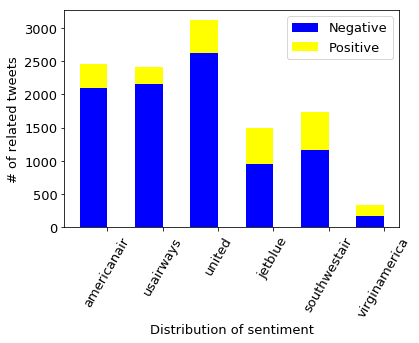

In [44]:
def ratio_2d(dataFrame,class1,attr1,label2,attr2):
    num = []
    nega = []
    for i in class1:
        num.append(dataFrame[dataFrame[attr1]==i].iloc[:,0].count())
        nega.append(dataFrame[(dataFrame[attr1]==i) & (dataFrame[attr2]==label2)].iloc[:,0].count())
    num = np.array(num)
    nega = np.array(nega)
    ratio = nega / num
    return num,ratio

airlines = ['americanair','usairways','united','jetblue','southwestair','virginamerica']
num,ratio = ratio_2d(airline_tweets,airlines,'airline','negative','sentiment')

negative = num * ratio
positive = num * (1-ratio)

plt.rc('font', family='DejaVu Sans', size=13)
width=0.5
idx = np.arange(len(airlines))
plt.bar(idx, negative, width, color='blue', label='Negative')
plt.bar(idx, positive, width, bottom=negative, color='yellow', label='Positive')
plt.xlabel('Distribution of sentiment')
plt.ylabel('# of related tweets')
plt.xticks(idx+width/2, airlines, rotation=60)
plt.legend()

From the graph above, we can see that although airline virginAmerica doesn't have the most popularity, it's ratio of positive feedback is relatively higher. Comparatively, USAirways has high popularity but it's ratio of positive feedback is lowest.

### Q3-Bonus
Instead of using "tf-idf" as the feature generation method, we use k-most-common terms as the feature. And we try binary encoding and frequency encoding on chosen terms.

In [ ]:
# MOST-COMMON-BINARY


#### Explore alternative classification methods and compare their performance to that of the logistic regression model.